## import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import os
import glob
import pandas as pd
from pathlib import Path
import seaborn as sns
sns.set()

In [ ]:
data_path = Path.cwd().parent/"data"
plot_dir =  Path.cwd().parent/"plots"

In [ ]:
sidelink_df = pd.read_parquet("/content/sidelink_dataframe.parquet")
sidelink_df = sidelink_df.assign(**{"SL3 Role": 'None'})
sidelink_df.loc[sidelink_df.syncref_source, "SL3 Role"] = "TX"
sidelink_df.loc[sidelink_df.syncref_destination, "SL3 Role"] = "RX"

In [ ]:
plot_df = sidelink_df.query("`Source` != `Destination` & `SL3 Role` == 'None'")
plot_df = plot_df.assign(link=lambda x: x.Source.astype(str)+r"$\rightarrow$"+x.Destination.astype(str))

In [ ]:
plot_df.columns

Index(['Source', 'Destination', 'Scenario', 'time_epoch', 'SNR', 'RSRP',
       'RSSI', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER', 'SubFrame_LENGHT',
       'Rx_power', 'MCS', 'Received Packets', 'ts_gps_source',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'precipProbability_source', 'temperature_source',
       'apparentTemperature_source', 'dewPoint_source', 'humidity_source',
       'pressure_source', 'windSpeed_source', 'cloudCover_source',
       'uvIndex_source', 'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Street_Name_source', 'Traffic_Distance_source',
       'Pos_in_Ref_Round_source', 'device_source', 'area_source',
       'ts_gps_destination', 'Latitude_destination', 'Longitude_destination',
       'Altitude_destination', 'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_desti

# Plot 1 - Distance vs. PER

In [ ]:
distq_df = plot_df.assign(distance_q=pd.qcut(plot_df['distance'],100, labels=False))
distq_map = distq_df[['distance','distance_q']].groupby(['distance_q']).mean()

distq_df['distance'] = distq_df['distance_q'].map(distq_map['distance'])

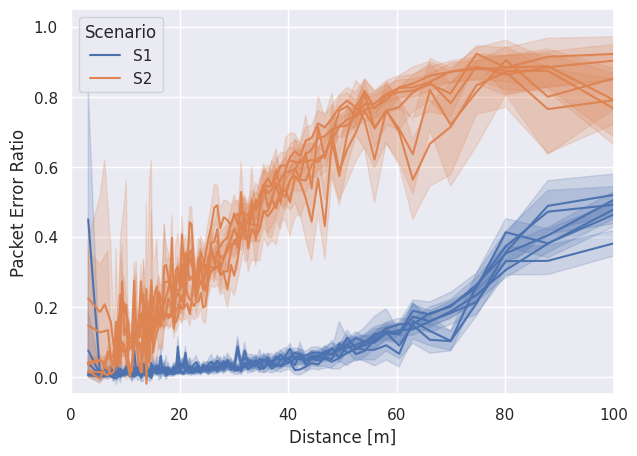

In [ ]:
per_lim = (-0.05,1.05)
dist_lim = (0, 100)


ax = sns.lineplot(distq_df, x='distance', y='Packet_error_ratio', hue="Scenario",
                  style="link", dashes=[""]*6)

plt.xlabel("Distance [m]")
plt.ylabel("Packet Error Ratio")
plt.xlim(dist_lim)
plt.ylim(per_lim)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3], title='Scenario')

plt.gcf().set_size_inches(7, 5)
#plt.savefig(plot_dir/"sl_dist_per.pdf", bbox_inches='tight')

<ipython-input-63-0681090da66f>:9: RuntimeWarning: divide by zero encountered in log10
  return PL0 + 10 * n * np.log10(distance)


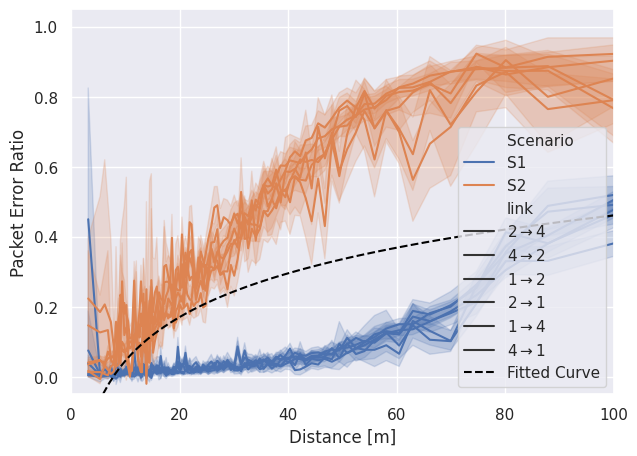

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

# Your data in distq_df should be provided
# Define the path loss model
def path_loss_model(distance, PL0, n):
    return PL0 + 10 * n * np.log10(distance)

# Perform curve fitting
params, covariance = curve_fit(path_loss_model, distq_df['distance'], distq_df['Packet_error_ratio'], p0=[-30, 2])

# Extract the parameters
PL0, n = params

# Plot the data and the fitted curve
plt.figure(figsize=(7, 5))
sns.lineplot(data=distq_df, x='distance', y='Packet_error_ratio', hue="Scenario",
             style="link", dashes=[""]*6)
plt.xlabel("Distance [m]")
plt.ylabel("Packet Error Ratio")
plt.xlim(dist_lim)
plt.ylim(per_lim)

# Add the fitted curve to the plot
distance_range = np.linspace(dist_lim[0], dist_lim[1], 100)
plt.plot(distance_range, path_loss_model(distance_range, PL0, n), label='Fitted Curve', color='black', linestyle='--')
plt.legend()

plt.show()


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# Define the log-distance path loss model
def log_distance_model(d, A, B):
    return A * (1 / d)**B

# Perform curve fitting
params, covariance = curve_fit(log_distance_model, distq_df['distance'], distq_df['Packet_error_ratio'])

# Extract the parameters
A, B = params

# Interpretation
print(f"Estimated Parameters - A: {A}, B: {B}")


Estimated Parameters - A: 0.016977183900525012, B: -0.7433381722696161


# Plot 2 - SNR vs. PER/distance


In [ ]:
snrq_df = plot_df.assign(snr_q= pd.qcut(plot_df['SNR'], 100, labels=False))
snrq_map = snrq_df[['SNR','snr_q']].groupby(['snr_q']).mean()

snrq_df['SNR'] = snrq_df['snr_q'].map(snrq_map['SNR'])

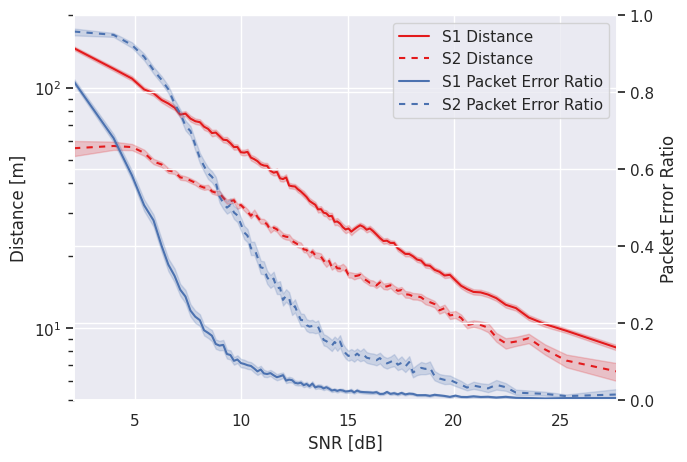

In [ ]:
f = plt.figure()

dist_lim = (5,200)
per_lim = (0, 1)
snr_lim = snrq_df['SNR'].min(), snrq_df['SNR'].max()

dashes = ("", (3, 3))

ax1 = plt.gca()
ax2 = plt.twinx()
perplot = sns.lineplot(snrq_df, x='SNR', y='Packet_error_ratio', legend=False, style="Scenario", dashes=dashes,
                       ax =ax2)
distplot = sns.lineplot(snrq_df, x='SNR', y='distance', style="Scenario", dashes=dashes, legend=False,
                        ax=ax1, color=sns.color_palette("Paired")[5])
distplot.set(yscale="log")

ax1.set_xlim(snr_lim)
ax1.set_ylim(dist_lim)
ax2.set_ylim(per_lim)


ax1.set_xlabel("SNR [dB]")
ax1.set_ylabel("Distance [m]")
ax2.set_ylabel("Packet Error Ratio")

lines = ax1.get_lines()[:2] + ax2.get_lines()[:2]
ax2.legend(lines, ["S1 Distance", "S2 Distance",
                   "S1 Packet Error Ratio", "S2 Packet Error Ratio"])
#plt.title(f"Scenario {scen}: PC{src} to PC{dst}")

plt.gcf().set_size_inches(7, 5)
#plt.savefig(plot_dir/"DistSnrPer.pdf", bbox_inches='tight')

For a given PER threshold, the calculated SNR threshold represents the minimum SNR level required to achieve that specific error rate. If the actual SNR of a transmission is above this threshold, you can consider the transmission as successful, meaning that the system is likely to achieve the desired low error rate.

Conversely, if the actual SNR of a transmission is below the calculated SNR threshold for a specific PER threshold, you may consider the transmission as failed or unreliable. In such cases, the system is unlikely to achieve the desired error rate, and the risk of errors in data transmission is higher.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate physical layer parameters
sidelink_df['SNR_margin'] = sidelink_df['SNR'] - sidelink_df['NOISE POWER']
sidelink_df['Throughput'] = sidelink_df['Packet_transmission_rate_hz'] * (1 - sidelink_df['Packet_error_ratio'])
sidelink_df['Signal_Power'] = sidelink_df['SNR'] - sidelink_df['NOISE POWER']




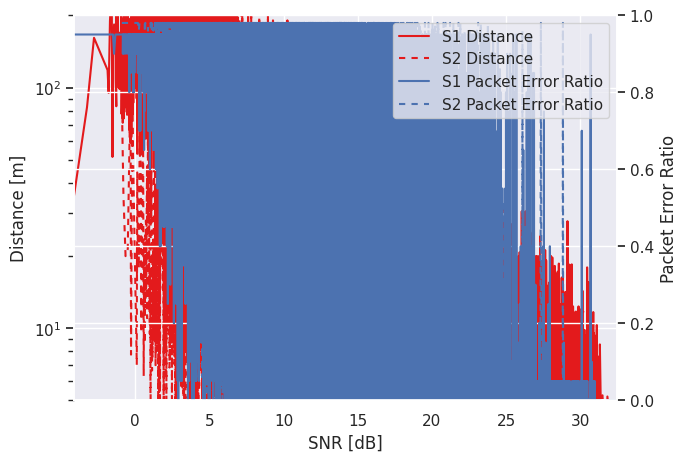

In [ ]:
f = plt.figure()

dist_lim = (5, 200)
per_lim = (0, 1)
snr_lim = (sidelink_df['SNR'].min(), sidelink_df['SNR'].max())

dashes = ("", (3, 3))

ax1 = plt.gca()
ax2 = plt.twinx()

perplot = sns.lineplot(data=sidelink_df, x='SNR', y='Packet_error_ratio', legend=False, style="Scenario", dashes=dashes, ax=ax2)
distplot = sns.lineplot(data=sidelink_df, x='SNR', y='distance', style="Scenario", dashes=dashes, legend=False, ax=ax1, color=sns.color_palette("Paired")[5])
distplot.set(yscale="log")

ax1.set_xlim(snr_lim)
ax1.set_ylim(dist_lim)
ax2.set_ylim(per_lim)

ax1.set_xlabel("SNR [dB]")
ax1.set_ylabel("Distance [m]")
ax2.set_ylabel("Packet Error Ratio")

lines = ax1.get_lines()[:2] + ax2.get_lines()[:2]
ax2.legend(lines, ["S1 Distance", "S2 Distance", "S1 Packet Error Ratio", "S2 Packet Error Ratio"])

plt.gcf().set_size_inches(7, 5)

# Optionally, save the plot to a file
# plt.savefig("DistSnrPer.pdf", bbox_inches='tight')

# Show the plot
plt.show()

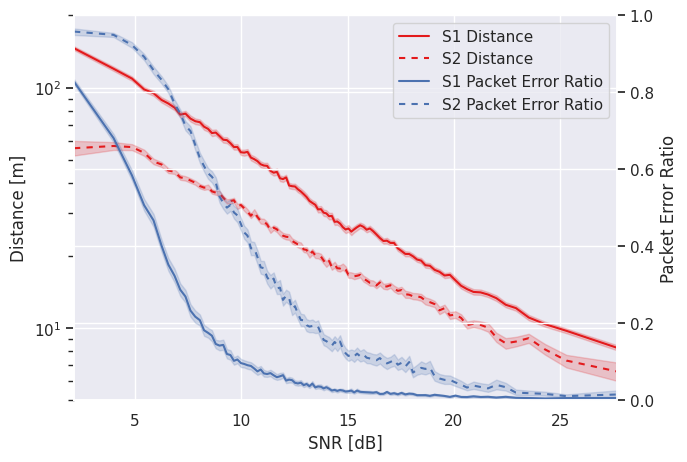

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your data ranges and style
dist_lim = (5, 200)
per_lim = (0, 1)
snr_lim = (snrq_df['SNR'].min(), snrq_df['SNR'].max())
dashes = ("", (3, 3))

# Create the figure and get the current axes
f = plt.figure()
ax1 = plt.gca()
ax2 = plt.twinx()

# Create line plots for Distance and Packet Error Ratio with different styles
perplot = sns.lineplot(data=snrq_df, x='SNR', y='Packet_error_ratio', legend=False, style="Scenario", dashes=dashes, ax=ax2)
distplot = sns.lineplot(data=snrq_df, x='SNR', y='distance', style="Scenario", dashes=dashes, legend=False, ax=ax1, color=sns.color_palette("Paired")[5])

# Set the y-scale of the Distance plot to logarithmic
distplot.set(yscale="log")

# Set the limits for both axes
ax1.set_xlim(snr_lim)
ax1.set_ylim(dist_lim)
ax2.set_ylim(per_lim)

# Set labels for the x and y-axes for both plots
ax1.set_xlabel("SNR [dB]")
ax1.set_ylabel("Distance [m]")
ax2.set_ylabel("Packet Error Ratio")

# Create a legend for the lines
lines = ax1.get_lines()[:2] + ax2.get_lines()[:2]
ax2.legend(lines, ["S1 Distance", "S2 Distance", "S1 Packet Error Ratio", "S2 Packet Error Ratio"])

# Set the size of the plot
plt.gcf().set_size_inches(7, 5)

# Optionally, save the plot to a file
# plt.savefig(plot_dir/"DistSnrPer.pdf", bbox_inches='tight')

# Show the plot
plt.show()


#new coding


#Reliability

In [ ]:
x=plot_df.drop(columns='Packet_error_ratio')
y=plot_df['Packet_error_ratio']

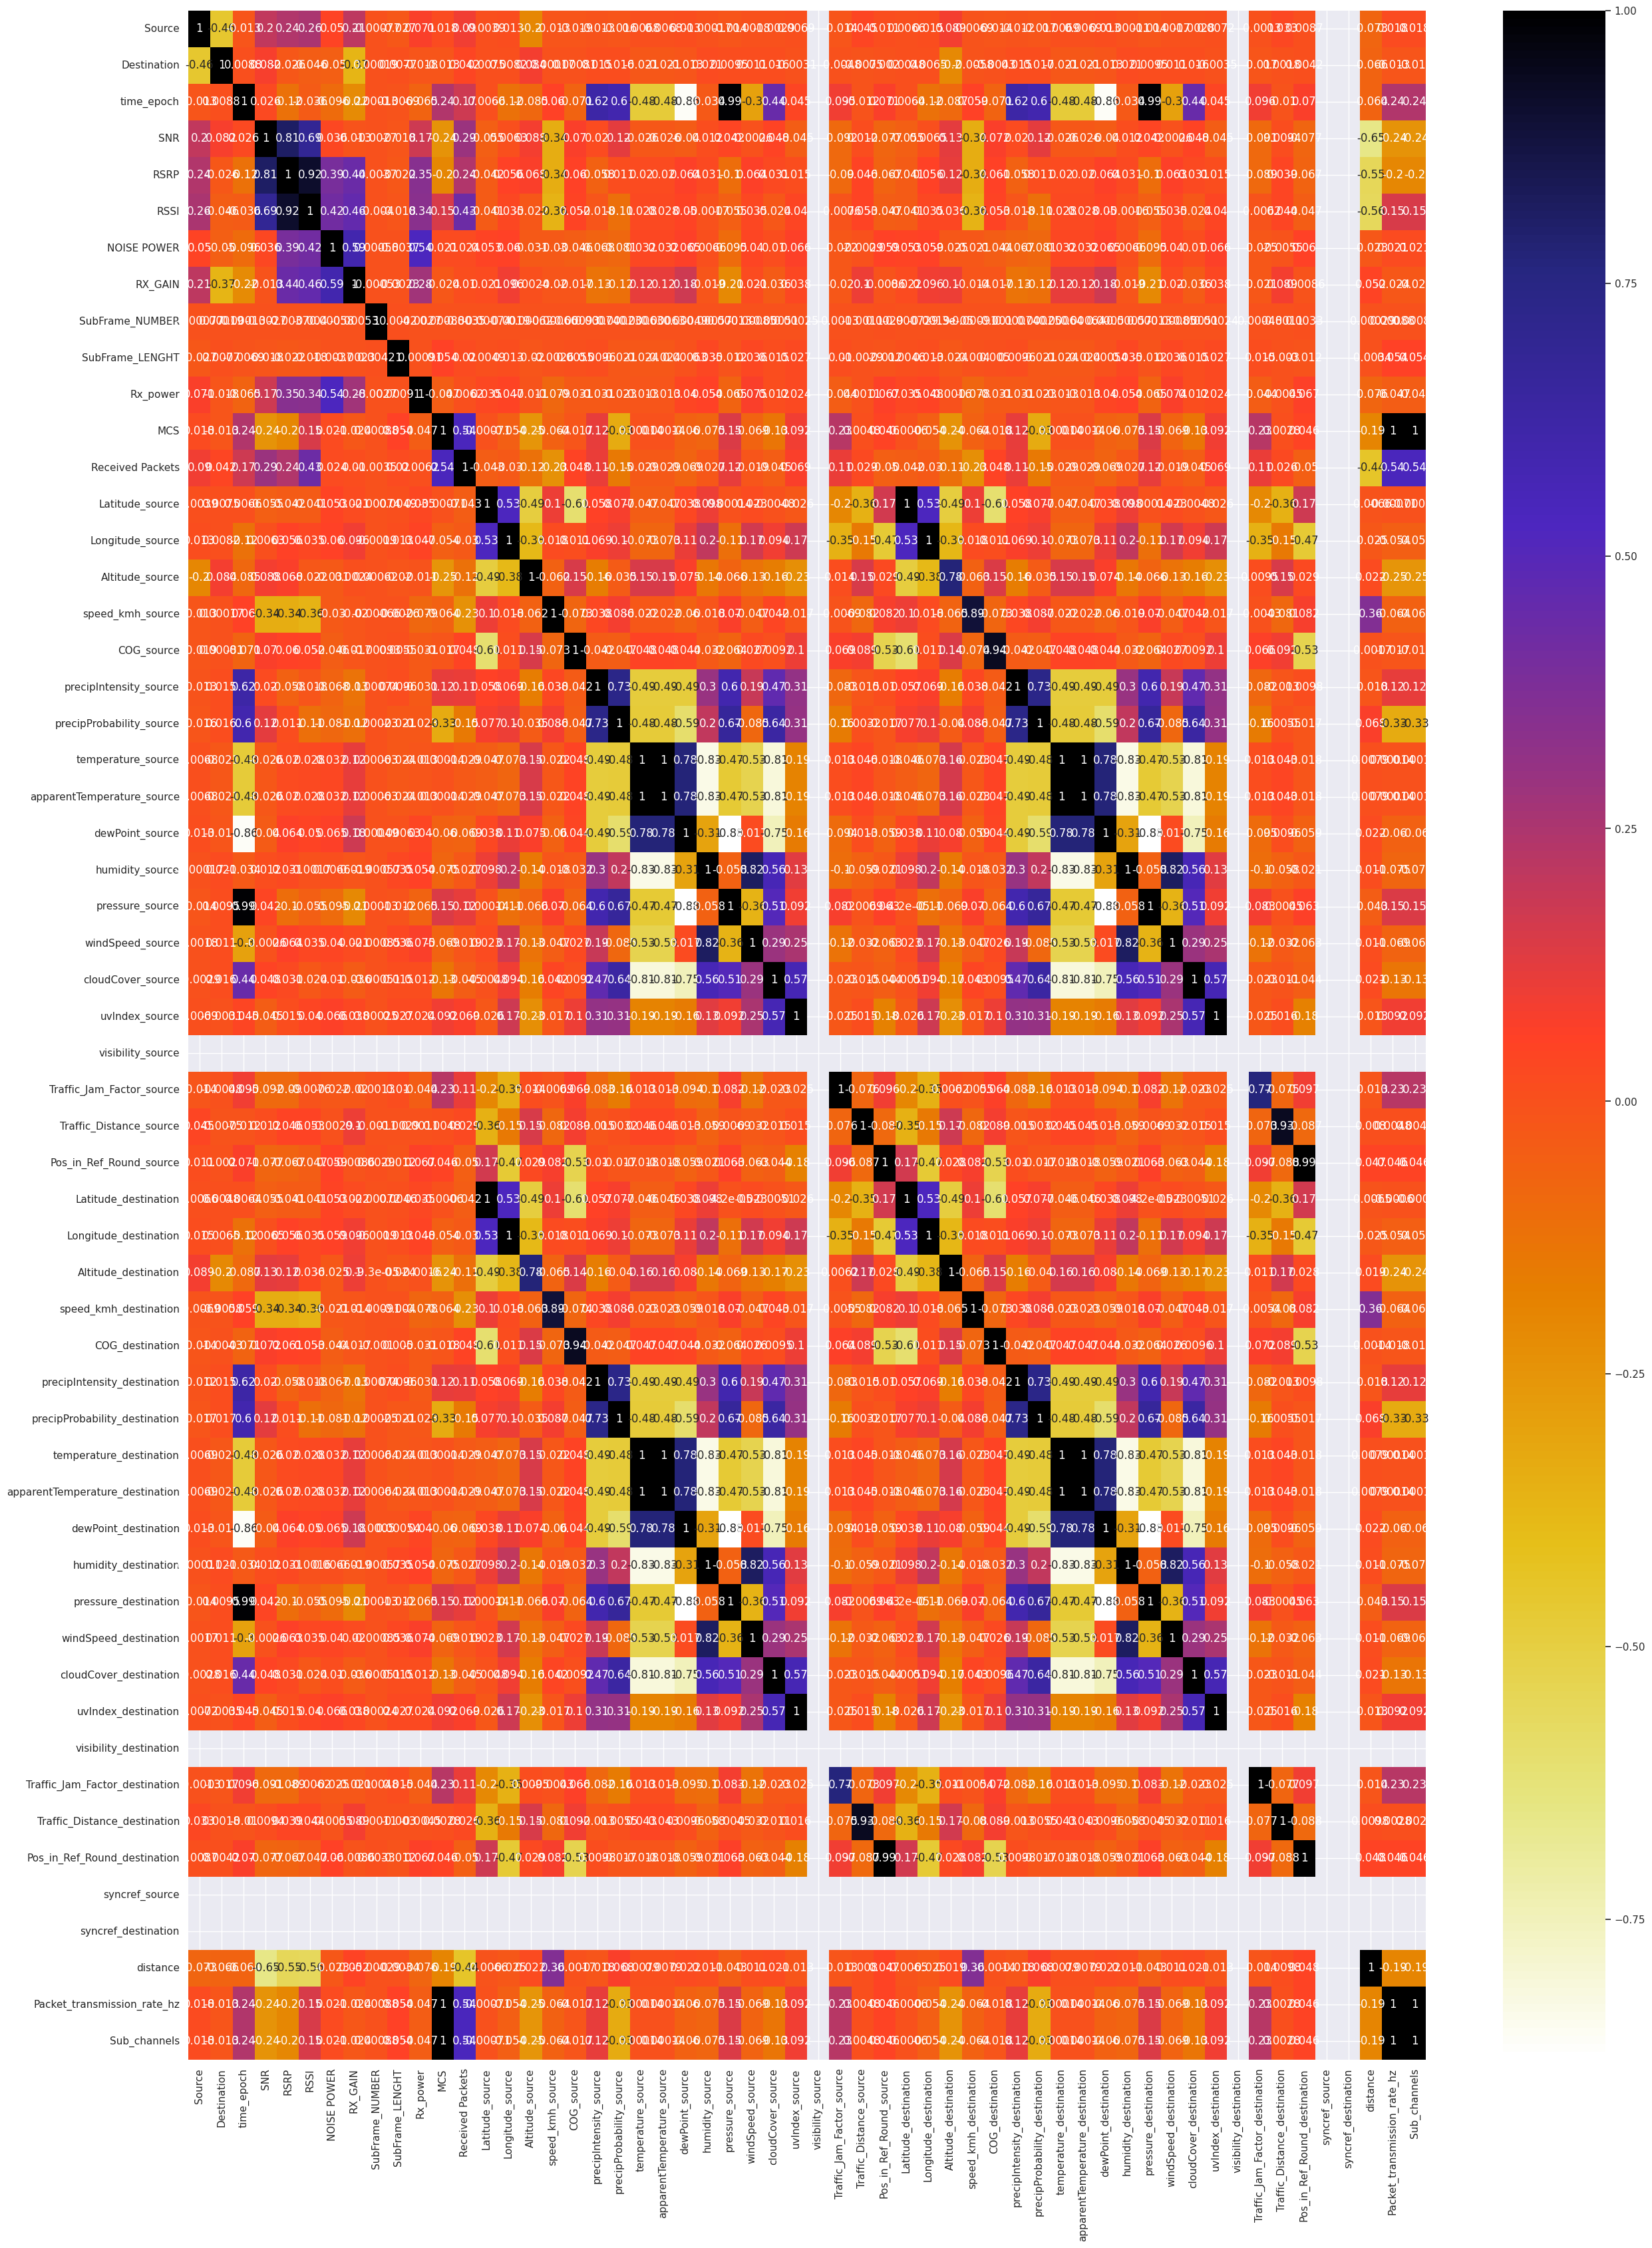

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,40))
cor=x.corr(numeric_only=True)
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
col_corr=set()
corr_matrix=x.corr(numeric_only=True)
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i,j])>0.7:
      column=corr_matrix.columns[i]
      col_corr.add(column)
a=len(set(col_corr))
print("correlated features: ",a)
print("features are: ",col_corr)

correlated features:  29
features are:  {'precipProbability_source', 'COG_destination', 'speed_kmh_destination', 'windSpeed_destination', 'dewPoint_source', 'RSSI', 'uvIndex_destination', 'humidity_destination', 'Longitude_destination', 'dewPoint_destination', 'Pos_in_Ref_Round_destination', 'Latitude_destination', 'temperature_destination', 'precipIntensity_destination', 'precipProbability_destination', 'Traffic_Distance_destination', 'cloudCover_source', 'humidity_source', 'Traffic_Jam_Factor_destination', 'pressure_destination', 'Packet_transmission_rate_hz', 'cloudCover_destination', 'RSRP', 'windSpeed_source', 'Sub_channels', 'pressure_source', 'apparentTemperature_source', 'apparentTemperature_destination', 'Altitude_destination'}


In [ ]:
x_noncorr=x.drop(col_corr,axis=1)

In [ ]:
x_noncorr.shape

(167840, 38)

In [ ]:
col_drop=['Source','Destination','Scenario','Traffic_Street_Name_source','device_source','area_source','Traffic_Street_Name_destination','device_destination','area_destination','syncref_source','syncref_destination','SL3 Role','link']
x_noncorr.drop(columns=col_drop, inplace=True)

In [ ]:
x_noncorr.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'ts_gps_source', 'Latitude_source', 'Longitude_source',
       'Altitude_source', 'speed_kmh_source', 'COG_source',
       'precipIntensity_source', 'temperature_source', 'uvIndex_source',
       'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source',
       'ts_gps_destination', 'visibility_destination', 'distance'],
      dtype='object')

In [ ]:
col=['visibility_source','visibility_destination']
x_noncorr.drop(columns=col,inplace=True)

In [ ]:
cols=['ts_gps_source','ts_gps_destination']
x_noncorr.drop(columns=cols,inplace=True)

In [ ]:
x_noncorr.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'temperature_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source', 'distance'],
      dtype='object')

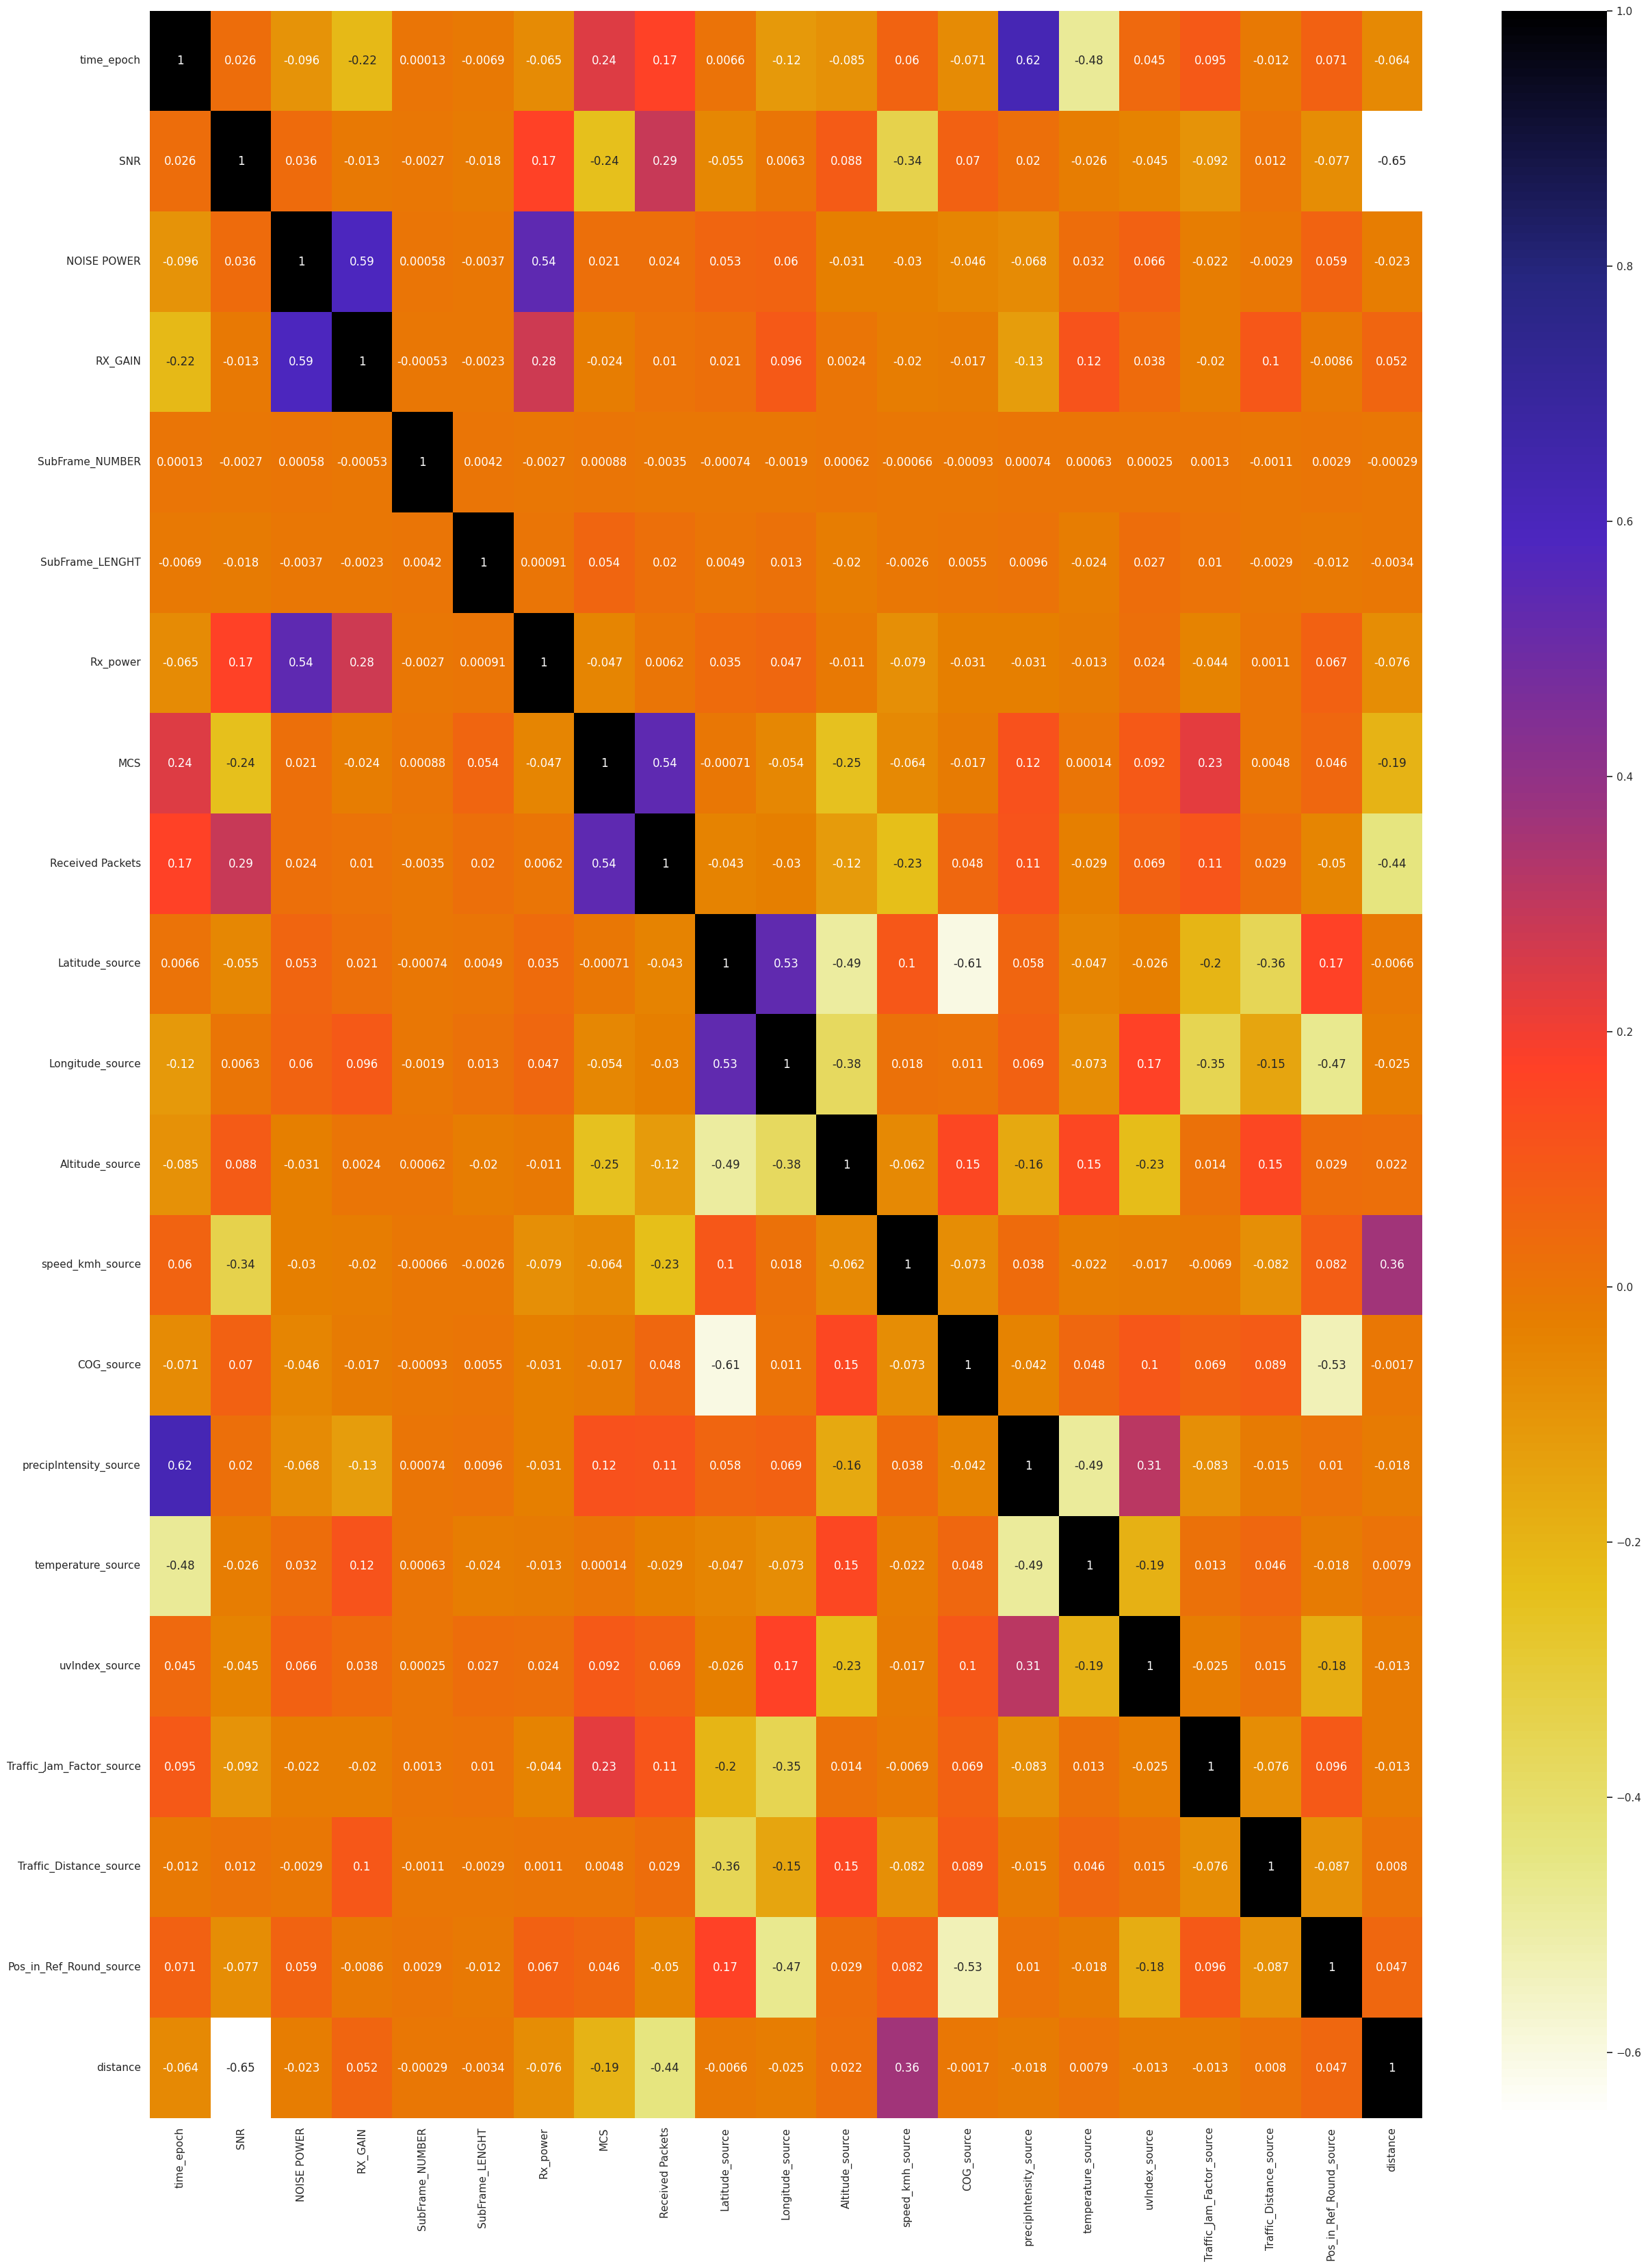

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,40))
cor=x_noncorr.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
data1=x_noncorr
data1['Packet_error_ratio']=y

In [ ]:
x_noncorr.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'temperature_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source', 'distance',
       'Packet_error_ratio'],
      dtype='object')

In [ ]:
x_data=x_noncorr.drop('Packet_error_ratio',axis=1)

In [ ]:
x_data.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'temperature_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source', 'distance'],
      dtype='object')

In [ ]:
y=x_noncorr['Packet_error_ratio']

In [ ]:
data1

time_epoch        SNR  NOISE POWER  RX_GAIN  \
timestamp                                                                  
2021-06-22 09:51:48+02:00  1.624348e+09  14.144092     0.002013     44.0   
2021-06-22 09:51:48+02:00  1.624348e+09  15.227671     0.004633     45.0   
2021-06-22 09:51:49+02:00  1.624348e+09  15.273688     0.006282     45.0   
2021-06-22 09:51:49+02:00  1.624348e+09  14.295098     0.002737     44.0   
2021-06-22 09:51:50+02:00  1.624348e+09  15.494669     0.007427     45.0   
...                                 ...        ...          ...      ...   
2021-06-23 17:06:59+02:00  1.624461e+09   9.879130     0.000876     40.0   
2021-06-23 17:07:00+02:00  1.624461e+09  12.810686     0.000524     40.0   
2021-06-23 17:07:00+02:00  1.624461e+09  13.532171     0.000349     40.0   
2021-06-23 17:07:00+02:00  1.624461e+09   6.292670     0.000409     40.0   
2021-06-23 17:07:00+02:00  1.624461e+09   4.318350     0.000473     43.0   

                           SubFrame_NUMBER  SubFrame_LENGHT  Rx_power  MCS  \
timestamp                                                                    
2021-06-22 09:51:48+02:00       426.941176         2.470588  0.053156    8   
2021-06-22 09:51:48+02:00       463.300000         0.300000  0.098266    8   
2021-06-22 09:51:49+02:00       102.500000         0.150000  0.123603    8   
2021-06-22 09:51:49+02:00       100.526316         4.789474  0.066103    8   
2021-06-22 09:51:50+02:00       200.294118         1.470588  0.095582    8   
...                                    ...              ...       ...  ...   
2021-06-23 17:06:59+02:00       415.088889         5.977778  0.011695   12   
2021-06-23 17:07:00+02:00       493.761905         3.666667  0.013316   12   
2021-06-23 17:07:00+02:00       504.914286         1.428571  0.010054   12   
2021-06-23 17:07:00+02:00       510.857143         7.000000  0.002345   12   
2021-06-23 17:07:00+02:00       563.000000         1.000000  0.001819   12   

                           Received Packets  Latitude_source  ...  \
timestamp                                                     ...   
2021-06-22 09:51:48+02:00                17        52.513440  ...   
2021-06-22 09:51:48+02:00                20        52.513383  ...   
2021-06-22 09:51:49+02:00                20        52.513370  ...   
2021-06-22 09:51:49+02:00                19        52.513417  ...   
2021-06-22 09:51:50+02:00                17        52.513362  ...   
...                                     ...              ...  ...   
2021-06-23 17:06:59+02:00                45        52.515718  ...   
2021-06-23 17:07:00+02:00                21        52.515732  ...   
2021-06-23 17:07:00+02:00                35        52.515725  ...   
2021-06-23 17:07:00+02:00                 7        52.515680  ...   
2021-06-23 17:07:00+02:00                 1        52.515725  ...   

                           speed_kmh_source  COG_source  \
timestamp                                                 
2021-06-22 09:51:48+02:00           31.8544       250.1   
2021-06-22 09:51:48+02:00           22.9648       230.3   
2021-06-22 09:51:49+02:00           22.4092       233.4   
2021-06-22 09:51:49+02:00           33.1508       255.9   
2021-06-22 09:51:50+02:00           20.7424       236.6   
...                                     ...         ...   
2021-06-23 17:06:59+02:00           32.0396        79.0   
2021-06-23 17:07:00+02:00           33.5212        79.2   
2021-06-23 17:07:00+02:00           35.5584        81.8   
2021-06-23 17:07:00+02:00           36.8548        88.8   
2021-06-23 17:07:00+02:00           35.5584        81.8   

                           precipIntensity_source  temperature_source  \
timestamp                                                               
2021-06-22 09:51:48+02:00                  0.0653               18.13   
2021-06-22 09:51:48+02:00                  0.0653               18.13   
2021-06-22 09:51:49+02:00                  0.0653               18.

In [ ]:
data1.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'temperature_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source', 'distance',
       'Packet_error_ratio'],
      dtype='object')



```
# This is formatted as code
```

GRU code for relliability

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
#from tensorflow.keras.optimizers import Adam
# Assuming your data is in a DataFrame called df
# Make sure your data is preprocessed and missing values are handled appropriately
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (assuming time series data)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build GRU model
model = Sequential()
model.add(GRU(units=64, activation='tanh', return_sequences=True))  # First GRU layer
model.add(GRU(units=64, activation='tanh'))  # Second GRU layer (without return_sequences)
model.add(Dense(units=1))


# Compile model with a custom learning rate
#custom_optimizer = Adam(learning_rate=0.1)  # You can adjust the learning rate
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Epoch 1/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.0051 - val_loss: 1.3910e-04
Epoch 2/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 6.8969e-05 - val_loss: 5.0095e-05
Epoch 3/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 3.9771e-05 - val_loss: 4.7157e-05
Epoch 4/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 4.4902e-05 - val_loss: 8.9488e-06
Epoch 5/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.6812e-05 - val_loss: 7.8135e-06
Epoch 6/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 2.2300e-05 - val_loss: 8.2526e-06
Epoch 7/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2.7595e-05 - val_loss: 1.8788e-05
Epoch 8/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 1.6668e-05 - val_loss: 7.8198e-06
Epoch 9/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 2.3869e-05 - val_loss: 6.4944e-06
Epoch 10/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 1.7086e-05 - val_loss: 3.9462e-06
Epoch 11/20
3357/3357 ━━━━━━━━━━━

Bidirectional

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense
from keras import layers
#from tensorflow.keras.optimizers import Adam
# Assuming your data is in a DataFrame called df
# Make sure your data is preprocessed and missing values are handled appropriately
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (assuming time series data)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


# Build Bidirectional RNN model
model = Sequential()
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(None, 21))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(units=1))  # Output layer


# Compile model with a custom learning rate
#custom_optimizer = Adam(learning_rate=0.1)  # You can adjust the learning rate
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 86s 20ms/step - loss: 0.0059 - val_loss: 1.3842e-04
Epoch 2/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 6.3373e-05 - val_loss: 5.3718e-05
Epoch 3/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 6.4298e-05 - val_loss: 1.9163e-05
Epoch 4/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - loss: 4.3921e-05 - val_loss: 1.3972e-05
Epoch 5/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 3.1464e-05 - val_loss: 1.9071e-05
Epoch 6/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 2.5109e-05 - val_loss: 1.1440e-05
Epoch 7/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 2.1441e-05 - val_loss: 1.0340e-05
Epoch 8/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 2.4853e-05 - val_loss: 1.2419e-05
Epoch 9/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 1.6488e-05 - val_loss: 4.7878e-06
Epoch 10/20
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 1.3645e-05 - val_loss: 1.7588e-05
Epoch 11/20
3357/3357 ━━━━━━━━━



```
# This is formatted as code
```

#Throughput

In [ ]:
for i in plot_df['Scenario']:
  if i=="s1":
    plot_df['Throughput']=plot_df['Received Packets']*69*8
  else:
    plot_df['Throughput']=plot_df['Received Packets']*1000*8


In [ ]:
plot_df['Throughput'] = np.where(plot_df['Scenario'] == 's1',
                                 plot_df['Received Packets'] * 69*8,
                                 plot_df['Received Packets'] * 1000*8)


In [ ]:
plot_df.columns

Index(['Source', 'Destination', 'Scenario', 'time_epoch', 'SNR', 'RSRP',
       'RSSI', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER', 'SubFrame_LENGHT',
       'Rx_power', 'MCS', 'Received Packets', 'ts_gps_source',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'precipProbability_source', 'temperature_source',
       'apparentTemperature_source', 'dewPoint_source', 'humidity_source',
       'pressure_source', 'windSpeed_source', 'cloudCover_source',
       'uvIndex_source', 'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Street_Name_source', 'Traffic_Distance_source',
       'Pos_in_Ref_Round_source', 'device_source', 'area_source',
       'ts_gps_destination', 'Latitude_destination', 'Longitude_destination',
       'Altitude_destination', 'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_desti

In [ ]:
data2=plot_df

In [ ]:
data2.columns

Index(['Source', 'Destination', 'Scenario', 'time_epoch', 'SNR', 'RSRP',
       'RSSI', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER', 'SubFrame_LENGHT',
       'Rx_power', 'MCS', 'Received Packets', 'ts_gps_source',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'precipProbability_source', 'temperature_source',
       'apparentTemperature_source', 'dewPoint_source', 'humidity_source',
       'pressure_source', 'windSpeed_source', 'cloudCover_source',
       'uvIndex_source', 'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Street_Name_source', 'Traffic_Distance_source',
       'Pos_in_Ref_Round_source', 'device_source', 'area_source',
       'ts_gps_destination', 'Latitude_destination', 'Longitude_destination',
       'Altitude_destination', 'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_desti

In [ ]:
col_drop=['Source','Destination','Scenario','Traffic_Street_Name_source','device_source','area_source','Traffic_Street_Name_destination','device_destination','area_destination','syncref_source','syncref_destination','SL3 Role','link','visibility_source','visibility_destination','ts_gps_source','ts_gps_destination']
data2=data2.drop(columns=col_drop)

In [ ]:
plot_df.columns

Index(['Source', 'Destination', 'Scenario', 'time_epoch', 'SNR', 'RSRP',
       'RSSI', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER', 'SubFrame_LENGHT',
       'Rx_power', 'MCS', 'Received Packets', 'ts_gps_source',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'precipProbability_source', 'temperature_source',
       'apparentTemperature_source', 'dewPoint_source', 'humidity_source',
       'pressure_source', 'windSpeed_source', 'cloudCover_source',
       'uvIndex_source', 'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Street_Name_source', 'Traffic_Distance_source',
       'Pos_in_Ref_Round_source', 'device_source', 'area_source',
       'ts_gps_destination', 'Latitude_destination', 'Longitude_destination',
       'Altitude_destination', 'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_desti

In [ ]:
data2.shape

(167840, 52)

In [ ]:
data2.columns

Index(['time_epoch', 'SNR', 'RSRP', 'RSSI', 'NOISE POWER', 'RX_GAIN',
       'SubFrame_NUMBER', 'SubFrame_LENGHT', 'Rx_power', 'MCS',
       'Received Packets', 'Latitude_source', 'Longitude_source',
       'Altitude_source', 'speed_kmh_source', 'COG_source',
       'precipIntensity_source', 'precipProbability_source',
       'temperature_source', 'apparentTemperature_source', 'dewPoint_source',
       'humidity_source', 'pressure_source', 'windSpeed_source',
       'cloudCover_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source',
       'Latitude_destination', 'Longitude_destination', 'Altitude_destination',
       'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_destination', 'apparentTemperature_destination',
       'dewPoint_destination', 'humidity_destination', 'pressure_destination',
       'windSpeed_destination', 'cloudCover_destin

In [ ]:
data2['Throughput']

timestamp
2021-06-22 09:51:48+02:00    136000
2021-06-22 09:51:48+02:00    160000
2021-06-22 09:51:49+02:00    160000
2021-06-22 09:51:49+02:00    152000
2021-06-22 09:51:50+02:00    136000
                              ...  
2021-06-23 17:06:59+02:00    360000
2021-06-23 17:07:00+02:00    168000
2021-06-23 17:07:00+02:00    280000
2021-06-23 17:07:00+02:00     56000
2021-06-23 17:07:00+02:00      8000
Name: Throughput, Length: 167840, dtype: int64

In [ ]:
x_thr=data2.drop(columns='Throughput')
y_thr=data2['Throughput']

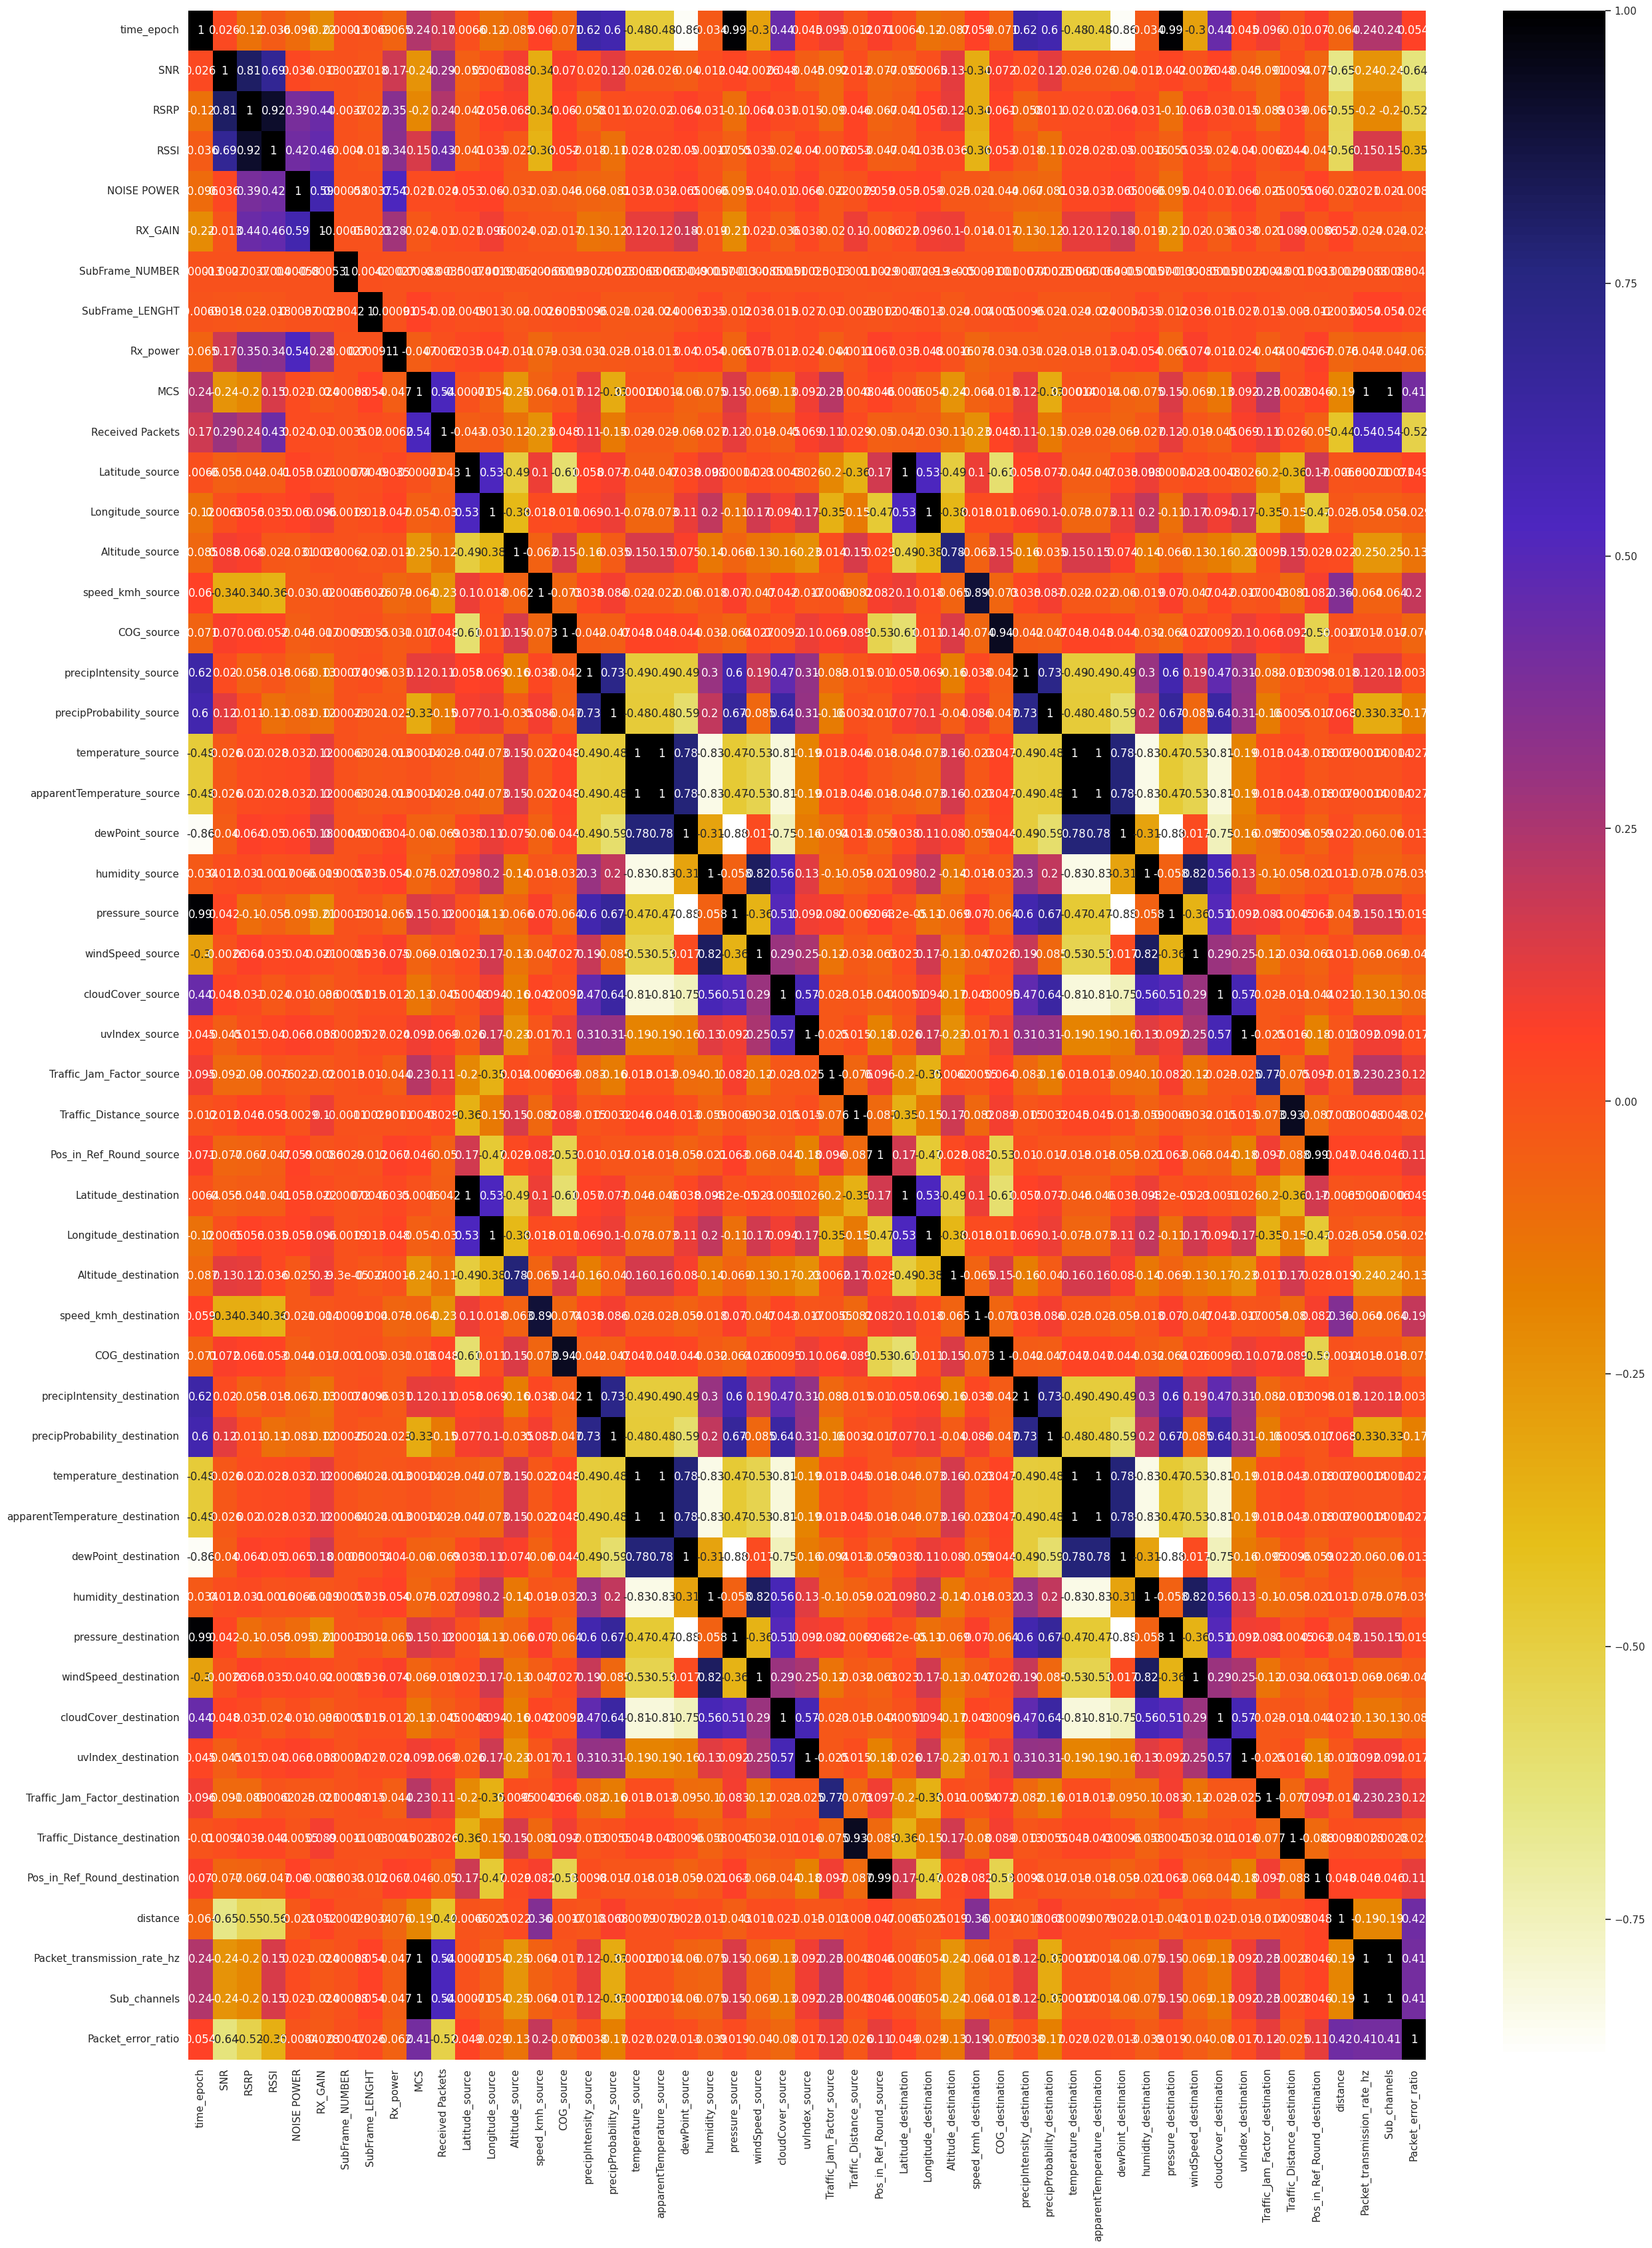

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,40))
cor=x_thr.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
col_corr=set()
corr_matrix=x_thr.corr()
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i,j])>0.7:
      column=corr_matrix.columns[i]
      col_corr.add(column)
a=len(set(col_corr))
print("correlated features: ",a)
print("features are: ",col_corr)

correlated features:  29
features are:  {'precipProbability_source', 'COG_destination', 'speed_kmh_destination', 'windSpeed_destination', 'dewPoint_source', 'RSSI', 'uvIndex_destination', 'humidity_destination', 'Longitude_destination', 'dewPoint_destination', 'Pos_in_Ref_Round_destination', 'Latitude_destination', 'temperature_destination', 'precipIntensity_destination', 'precipProbability_destination', 'Traffic_Distance_destination', 'cloudCover_source', 'humidity_source', 'Traffic_Jam_Factor_destination', 'pressure_destination', 'Packet_transmission_rate_hz', 'cloudCover_destination', 'RSRP', 'windSpeed_source', 'Sub_channels', 'pressure_source', 'apparentTemperature_source', 'apparentTemperature_destination', 'Altitude_destination'}


In [ ]:
x_thr.shape

(167840, 51)

In [ ]:
x_thr_noncorr=x_thr.drop(col_corr,axis=1)

In [ ]:
x_thr_noncorr.columns

Index(['time_epoch', 'SNR', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER',
       'SubFrame_LENGHT', 'Rx_power', 'MCS', 'Received Packets',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'temperature_source', 'uvIndex_source', 'Traffic_Jam_Factor_source',
       'Traffic_Distance_source', 'Pos_in_Ref_Round_source', 'distance',
       'Packet_error_ratio'],
      dtype='object')

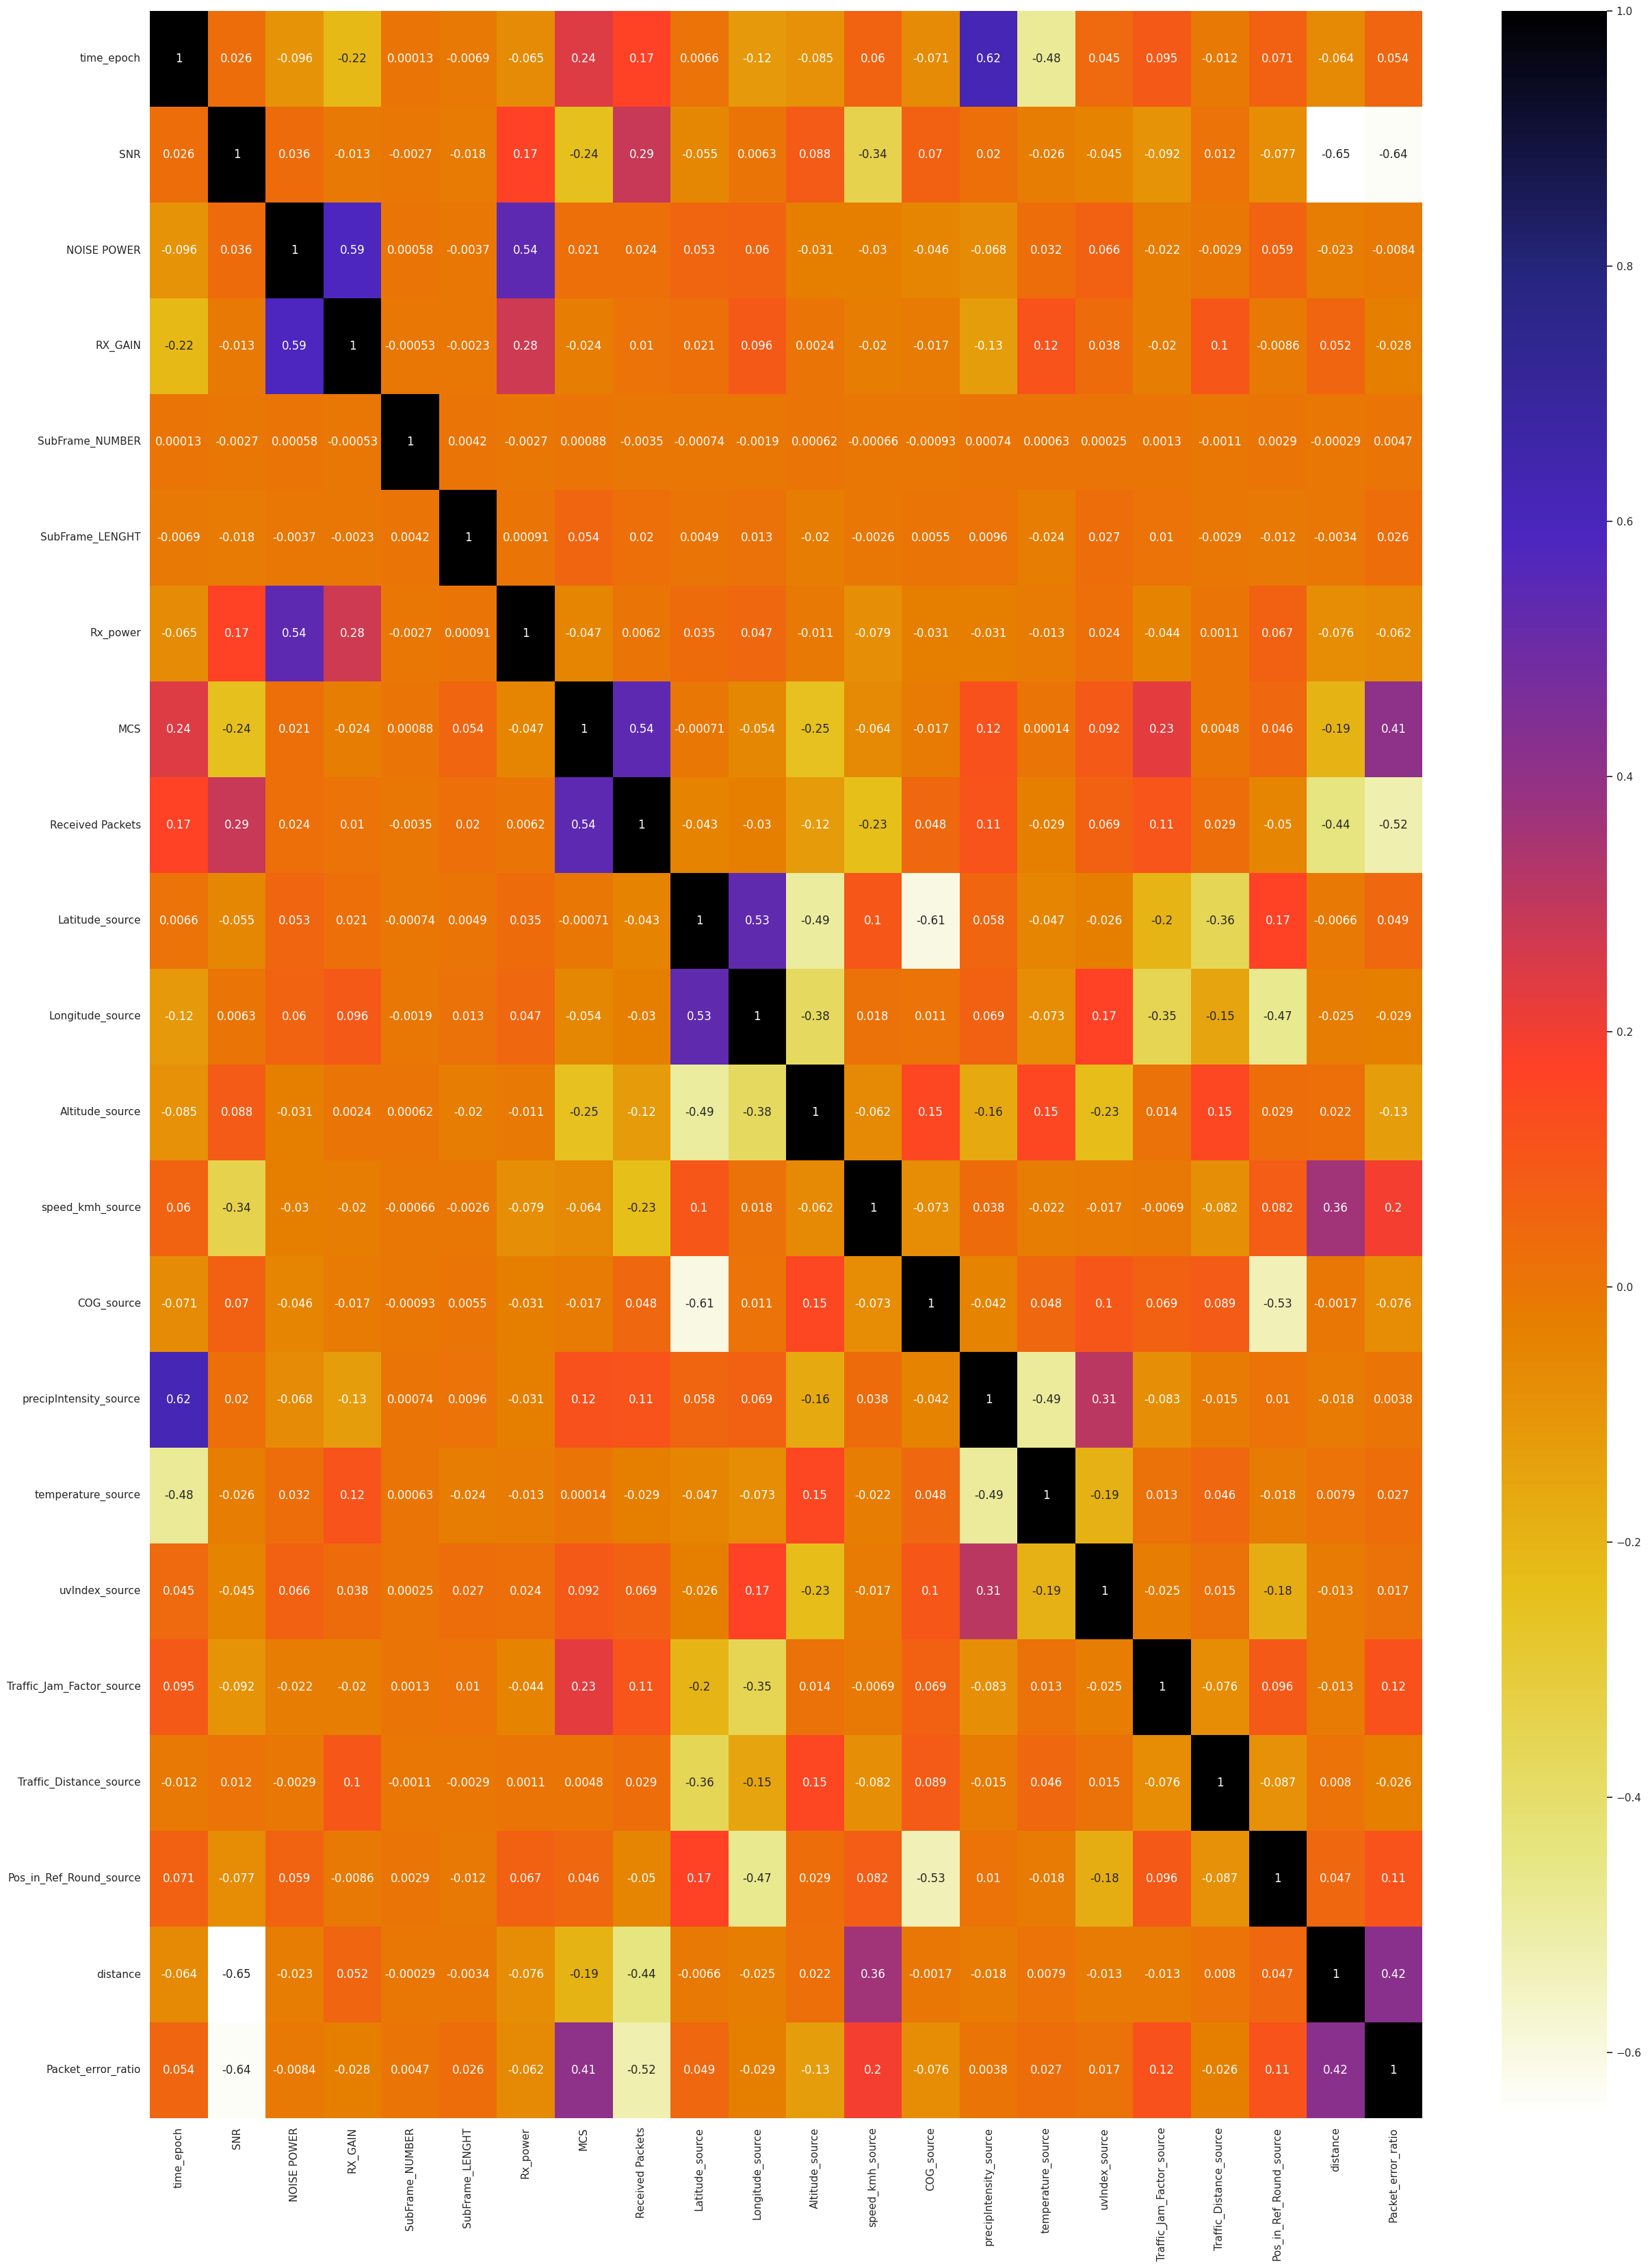

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,40))
cor=x_thr_noncorr.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

GRU model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import GRU, Dense



# Assuming 'features' is your DataFrame with the input features and 'throughput' is the throughput series.

# Step 1: Data Preparation
X = x_thr_noncorr.values # Convert DataFrame to numpy array
y = y_thr.values
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
# Reshape input to be [samples, time steps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential()
model.add(GRU(units=64, activation='tanh', return_sequences=True))  # First GRU layer
model.add(GRU(units=64, activation='tanh'))  # Second GRU layer (without return_sequences)
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=72, validation_data=(X_test, y_test), verbose=2)

# Step 4: Evaluate the Model
loss= model.evaluate(X_test, y_test, verbose=0)
print(f"Test RMSE: {loss}")
predictions_scaled = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions_scaled)
# Predict and compare against actual values
#predictions = model.predict(X_test)
# You can further plot these predictions against the true values or calculate other performance metrics.


Epoch 1/10
1865/1865 - 21s - 11ms/step - loss: 0.0025 - val_loss: 5.5129e-06
Epoch 2/10
1865/1865 - 11s - 6ms/step - loss: 4.6770e-06 - val_loss: 3.4801e-06
Epoch 3/10
1865/1865 - 20s - 10ms/step - loss: 7.0738e-06 - val_loss: 2.7980e-06
Epoch 4/10
1865/1865 - 9s - 5ms/step - loss: 6.8134e-06 - val_loss: 4.6697e-06
Epoch 5/10
1865/1865 - 10s - 5ms/step - loss: 6.1315e-06 - val_loss: 4.1846e-06
Epoch 6/10
1865/1865 - 10s - 5ms/step - loss: 5.5313e-06 - val_loss: 7.5751e-06
Epoch 7/10
1865/1865 - 9s - 5ms/step - loss: 5.6170e-06 - val_loss: 1.2846e-06
Epoch 8/10
1865/1865 - 19s - 10ms/step - loss: 5.0375e-06 - val_loss: 3.3264e-06
Epoch 9/10
1865/1865 - 22s - 12ms/step - loss: 3.8626e-06 - val_loss: 3.3688e-06
Epoch 10/10
1865/1865 - 17s - 9ms/step - loss: 3.8238e-06 - val_loss: 1.1682e-06
Test RMSE: 1.1681552223308245e-06
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [ ]:
#loss= model.evaluate(X_test, y_test, verbose=0)
#print(f"Test RMSE: {rmse}")
predictions_scaled = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions_scaled)

1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 55548342100.24279


In [ ]:
print(predictions,y_thr)

[[ 55827.293]
 [391426.53 ]
 [ 79693.08 ]
 ...
 [159598.73 ]
 [399093.38 ]
 [ 23208.988]] timestamp
2021-06-22 09:51:48+02:00    136000
2021-06-22 09:51:48+02:00    160000
2021-06-22 09:51:49+02:00    160000
2021-06-22 09:51:49+02:00    152000
2021-06-22 09:51:50+02:00    136000
                              ...  
2021-06-23 17:06:59+02:00    360000
2021-06-23 17:07:00+02:00    168000
2021-06-23 17:07:00+02:00    280000
2021-06-23 17:07:00+02:00     56000
2021-06-23 17:07:00+02:00      8000
Name: Throughput, Length: 167840, dtype: int64


bidirectional

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Bidirectional, Dense
from keras import layers



# Assuming 'features' is your DataFrame with the input features and 'throughput' is the throughput series.

# Step 1: Data Preparation
X = x_thr_noncorr.values # Convert DataFrame to numpy array
y = y_thr.values
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))
# Reshape input to be [samples, time steps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(None, 22))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model
model.fit(X_train, y_train, epochs=10, batch_size=72, validation_data=(X_test, y_test), verbose=2)

# Step 4: Evaluate the Model
loss= model.evaluate(X_test, y_test, verbose=0)
print(f"Test RMSE: {loss}")
predictions_scaled = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions_scaled)
# Predict and compare against actual values
#predictions = model.predict(X_test)
# You can further plot these predictions against the true values or calculate other performance metrics.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1865/1865 - 26s - 14ms/step - loss: 0.0033 - val_loss: 6.2527e-06
Epoch 2/10
1865/1865 - 13s - 7ms/step - loss: 5.2304e-06 - val_loss: 2.5755e-06
Epoch 3/10
1865/1865 - 21s - 11ms/step - loss: 4.1920e-06 - val_loss: 1.6149e-06
Epoch 4/10
1865/1865 - 21s - 11ms/step - loss: 5.3695e-06 - val_loss: 3.9339e-06
Epoch 5/10
1865/1865 - 14s - 7ms/step - loss: 4.2170e-06 - val_loss: 5.4898e-07
Epoch 6/10
1865/1865 - 21s - 11ms/step - loss: 4.0872e-06 - val_loss: 5.2117e-07
Epoch 7/10
1865/1865 - 19s - 10ms/step - loss: 3.2149e-06 - val_loss: 1.8420e-06
Epoch 8/10
1865/1865 - 21s - 11ms/step - loss: 3.1377e-06 - val_loss: 1.1186e-06
Epoch 9/10
1865/1865 - 21s - 11ms/step - loss: 3.0556e-06 - val_loss: 2.3570e-06
Epoch 10/10
1865/1865 - 21s - 11ms/step - loss: 2.6591e-06 - val_loss: 1.1438e-04
Test RMSE: 0.00011437907960498706
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
#loss= model.evaluate(X_test, y_test, verbose=0)
#print(f"Test RMSE: {rmse}")
predictions_scaled = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions_scaled)

1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [ ]:
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 53723870455.42518


In [ ]:
print(predictions,y_thr)

[[ 54343.797]
 [385030.78 ]
 [ 77067.49 ]
 ...
 [156787.05 ]
 [394310.2  ]
 [ 22506.254]] timestamp
2021-06-22 09:51:48+02:00    136000
2021-06-22 09:51:48+02:00    160000
2021-06-22 09:51:49+02:00    160000
2021-06-22 09:51:49+02:00    152000
2021-06-22 09:51:50+02:00    136000
                              ...  
2021-06-23 17:06:59+02:00    360000
2021-06-23 17:07:00+02:00    168000
2021-06-23 17:07:00+02:00    280000
2021-06-23 17:07:00+02:00     56000
2021-06-23 17:07:00+02:00      8000
Name: Throughput, Length: 167840, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
X_train, X_test, y_train, y_test = train_test_split(x_thr_noncorr, y_thr, test_size=0.2, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape data for LSTM input (assuming time series data)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(units=1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)
# Make predictions
y_pred = model.predict(X_test_reshaped)
# Evaluate the model
print(y_pred,y_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Epoch 1/20
3357/3357 [==============================] - 14s 4ms/step - loss: 55195521024.0000 - val_loss: 54393475072.0000
Epoch 2/20
3357/3357 [==============================] - 13s 4ms/step - loss: 53234798592.0000 - val_loss: 51785191424.0000
Epoch 3/20
3357/3357 [==============================] - 12s 4ms/step - loss: 50092265472.0000 - val_loss: 48160428032.0000
Epoch 4/20
3357/3357 [==============================] - 12s 4ms/step - loss: 46068932608.0000 - val_loss: 43768197120.0000
Epoch 5/20
3357/3357 [==============================] - 14s 4ms/step - loss: 41368035328.0000 - val_loss: 38818017280.0000
Epoch 6/20
3357/3357 [==============================] - 13s 4ms/step - loss: 36272607232.0000 - val_loss: 33615343616.0000
Epoch 7/20
3357/3357 [==============================] - 14s 4ms/step - loss: 31060088832.0000 - val_loss: 28429494272.0000
Epoch 8/20
3357/3357 [==============================] - 14s 4ms/step - loss: 25974960128.0000 - val_loss: 23505467392.0000
Epoch 9/20
3357/

In [ ]:
print(test_predictions)

[ 88000. 160000. 160000. ... 400000. 192000. 328000.]


In [ ]:
x_thr_noncorr.head()

time_epoch        SNR  NOISE POWER  RX_GAIN  \
timestamp                                                                  
2021-06-22 09:51:48+02:00  1.624348e+09  14.144092     0.002013     44.0   
2021-06-22 09:51:48+02:00  1.624348e+09  15.227671     0.004633     45.0   
2021-06-22 09:51:49+02:00  1.624348e+09  15.273688     0.006282     45.0   
2021-06-22 09:51:49+02:00  1.624348e+09  14.295098     0.002737     44.0   
2021-06-22 09:51:50+02:00  1.624348e+09  15.494669     0.007427     45.0   

                           SubFrame_NUMBER  SubFrame_LENGHT  Rx_power  MCS  \
timestamp                                                                    
2021-06-22 09:51:48+02:00       426.941176         2.470588  0.053156    8   
2021-06-22 09:51:48+02:00       463.300000         0.300000  0.098266    8   
2021-06-22 09:51:49+02:00       102.500000         0.150000  0.123603    8   
2021-06-22 09:51:49+02:00       100.526316         4.789474  0.066103    8   
2021-06-22 09:51:50+02:00       200.294118         1.470588  0.095582    8   

                           Received Packets  Latitude_source  ...  \
timestamp                                                     ...   
2021-06-22 09:51:48+02:00                17        52.513440  ...   
2021-06-22 09:51:48+02:00                20        52.513383  ...   
2021-06-22 09:51:49+02:00                20        52.513370  ...   
2021-06-22 09:51:49+02:00                19        52.513417  ...   
2021-06-22 09:51:50+02:00                17        52.513362  ...   

                           speed_kmh_source  COG_source  \
timestamp                                                 
2021-06-22 09:51:48+02:00           31.8544       250.1   
2021-06-22 09:51:48+02:00           22.9648       230.3   
2021-06-22 09:51:49+02:00           22.4092       233.4   
2021-06-22 09:51:49+02:00           33.1508       255.9   
2021-06-22 09:51:50+02:00           20.7424       236.6   

                           precipIntensity_source  temperature_source  \
timestamp                                                               
2021-06-22 09:51:48+02:00                  0.0653               18.13   
2021-06-22 09:51:48+02:00                  0.0653               18.13   
2021-06-22 09:51:49+02:00                  0.0653               18.13   
2021-06-22 09:51:49+02:00                  0.0653               18.13   
2021-06-22 09:51:50+02:00                  0.0653               18.13   

                           uvIndex_source  Traffic_Jam_Factor_source  \
timestamp                                                              
2021-06-22 09:51:48+02:00             3.0                    3.08926   
2021-06-22 09:51:48+02:00             3.0                    2.73675   
2021-06-22 09:51:49+02:00             3.0                    3.03573   
2021-06-22 09:51:49+02:00             3.0                    2.73675   
2021-06-22 09:51:50+02:00             3.0                    3.03573   

                           Traffic_Distance_source  Pos_in_Ref_Round_source  \
timestamp                                                                     
2021-06-22 09:51:48+02:00                 4.743369             15156.001352   
2021-06-22 09:51:48+02:00                16.470066             15118.046494   
2021-06-22 09:51:49+02:00                 0.015063             15118.046494   
2021-06-22 09:51:49+02:00                17.991729             15143.190884   
2021-06-22 09:51:50+02:00                 0.408620             15105.632141   

                            distance  Packet_error_ratio  
timestamp                                                 
2021-06-22 09:51:48+02:00  30.631466                0.15  
2021-06-22 09:51:48+02:00  30.631466                0.00  
2021-06-22 09:51:49+02:00  27.982724                0.00  
2021-06-22 09:51:49+02:00  27.982724                0.05  
2021-06-22 09:51:50+02:00  24.855905                0.15  

[5 rows x 22 columns]

In [ ]:
y_thr.head()

timestamp
2021-06-22 09:51:48+02:00    136000
2021-06-22 09:51:48+02:00    160000
2021-06-22 09:51:49+02:00    160000
2021-06-22 09:51:49+02:00    152000
2021-06-22 09:51:50+02:00    136000
Name: Throughput, dtype: int64

#delay

In [ ]:
plot_df['Pr_delay']=plot_df['distance']/(3*100000)

In [ ]:
plot_df['Pr_delay']

timestamp
2021-06-22 09:51:48+02:00    0.000102
2021-06-22 09:51:48+02:00    0.000102
2021-06-22 09:51:49+02:00    0.000093
2021-06-22 09:51:49+02:00    0.000093
2021-06-22 09:51:50+02:00    0.000083
                               ...   
2021-06-23 17:06:59+02:00    0.000045
2021-06-23 17:07:00+02:00    0.000047
2021-06-23 17:07:00+02:00    0.000047
2021-06-23 17:07:00+02:00    0.000118
2021-06-23 17:07:00+02:00    0.000164
Name: Pr_delay, Length: 167840, dtype: float64

In [ ]:
for i in plot_df['Scenario']:
  if i=="s1":
    plot_df['Tr_delay']=plot_df['Packet_transmission_rate_hz']*69*8/10000000
  else:
    plot_df['Tr_delay']=plot_df['Packet_transmission_rate_hz']*1000*8/10000000


In [ ]:
plot_df['Tr_delay']

timestamp
2021-06-22 09:51:48+02:00    0.016
2021-06-22 09:51:48+02:00    0.016
2021-06-22 09:51:49+02:00    0.016
2021-06-22 09:51:49+02:00    0.016
2021-06-22 09:51:50+02:00    0.016
                             ...  
2021-06-23 17:06:59+02:00    0.040
2021-06-23 17:07:00+02:00    0.040
2021-06-23 17:07:00+02:00    0.040
2021-06-23 17:07:00+02:00    0.040
2021-06-23 17:07:00+02:00    0.040
Name: Tr_delay, Length: 167840, dtype: float64

In [ ]:
plot_df['delay']=plot_df["Pr_delay"]+plot_df["Tr_delay"]

In [ ]:
plot_df['delay']

timestamp
2021-06-22 09:51:48+02:00    0.016102
2021-06-22 09:51:48+02:00    0.016102
2021-06-22 09:51:49+02:00    0.016093
2021-06-22 09:51:49+02:00    0.016093
2021-06-22 09:51:50+02:00    0.016083
                               ...   
2021-06-23 17:06:59+02:00    0.040045
2021-06-23 17:07:00+02:00    0.040047
2021-06-23 17:07:00+02:00    0.040047
2021-06-23 17:07:00+02:00    0.040118
2021-06-23 17:07:00+02:00    0.040164
Name: delay, Length: 167840, dtype: float64


GRU code for delay



In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GRU, Dense

y=plot_df['delay']
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping X to fit the LSTM input requirement: [samples, time steps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential()
model.add(GRU(units=64, activation='tanh', return_sequences=True))  # First GRU layer
model.add(GRU(units=64, activation='tanh'))  # Second GRU layer (without return_sequences)
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

# Training the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Optionally, evaluate the model on the test set
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test loss: {loss}')


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_11 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_12 (GRU)                         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 1.3926e-04 - val_loss: 4.3648e-06
Epoch 2/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - loss: 9.1837e-06 - val_loss: 4.3684e-06
Epoch 3/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1.1161e-06 - val_loss: 2.0553e-07
Epoch 4/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 3.6189e-07 - val_loss: 4.0221e-08
Epoch 5/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 2.2929e-07 - val_loss: 1.1304e-07
Epoch 6/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 1.2992e-07 - val_loss: 9.5906e-09
Epoch 7/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 5.4290e-08 - val_loss: 6.4820e-09
Epoch 8/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.9655e-08 - val_loss: 5.4954e-09
Epoch 9/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.9527e-08 - val_loss: 2.1904e-09
Epoch 10/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 3.2646e-08 - val_loss: 9.4338e-10
Epoch 11/100
3357/3

In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error: {mse}')


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error: 4.2019300310910914e-11


bidirectional

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, Dense
from keras import layers

y=plot_df['delay']
# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping X to fit the LSTM input requirement: [samples, time steps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(None, 22))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(units=1))  # Output layer

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary to check the architecture
model.summary()

# Training the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Optionally, evaluate the model on the test set
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test loss: {loss}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_20 (Bidirectional)     │ (None, None, 128)           │          44,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_21 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,825 (335.25 KB)

 Trainable params: 85,825 (335.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 2.2323e-05 - val_loss: 2.3925e-07
Epoch 2/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 9.0178e-07 - val_loss: 1.8429e-07
Epoch 3/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 2.2625e-07 - val_loss: 6.8764e-08
Epoch 4/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 1.0319e-07 - val_loss: 2.4565e-08
Epoch 5/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 3.9633e-08 - val_loss: 1.4417e-08
Epoch 6/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 2.3564e-08 - val_loss: 7.6584e-09
Epoch 7/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 2.1412e-08 - val_loss: 3.5865e-09
Epoch 8/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 9.8979e-09 - val_loss: 2.5030e-07
Epoch 9/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 2.0102e-08 - val_loss: 3.2461e-09
Epoch 10/100
3357/3357 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 8.4553e-09 - val_loss: 4.1563e-09
Epoch 11/100
3357/3

In [ ]:
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f'Mean Squared Error: {mse}')


1049/1049 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Squared Error: 2.862292924659123e-08
